# House Price Predictor Project
This is my code for my competition submission for the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/competitions/home-data-for-ml-course)

**Goal:** build a machine learning model to predict the sales price for each house. For each Id in the test set, I must predict the value of the **SalePrice** variable. 

Submissions are evaluated on **Root-Mean-Squared-Error** (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# Setting Up

In [416]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.tree import DecisionTreeRegressor

from scipy import stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# I will use this colourmap later
cmap = plt.get_cmap('coolwarm')

In [255]:
train_data = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")

In [99]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [321]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   float64
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Picking Features

In [213]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

There are a lot of features to choose from. I am going to focus on the ones that I think will have the most significant impact on housing price:
- **Quality and Condition:** Overall quality and condition ratings, kitchen quality, and heating quality provide a direct measure of the house's condition and materials, which are critical in determining price.
- **Size and Space:** Features such as living area square footage, basement area, first and second floor areas, total rooms, and garage size are direct indicators of the house's space and capacity, which significantly influence price.
- **Year Built and Remodel Date:** The age of the house and any renovations provide insight into the property's age and modernization level.
- **Location:** The neighborhood is crucial as location often dictates real estate prices.
- **Amenities:** Features like fireplaces, air conditioning, and garage are amenities that can add value to a property.



In [415]:
features = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GrLivArea', 
            'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'GarageCars', 'GarageArea', 'FullBath', 
            'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 
            'GarageYrBlt', 'LotArea', 'Neighborhood', 'BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF', 'HeatingQC', 'CentralAir', 'BedroomAbvGr']

# Understanding the Data

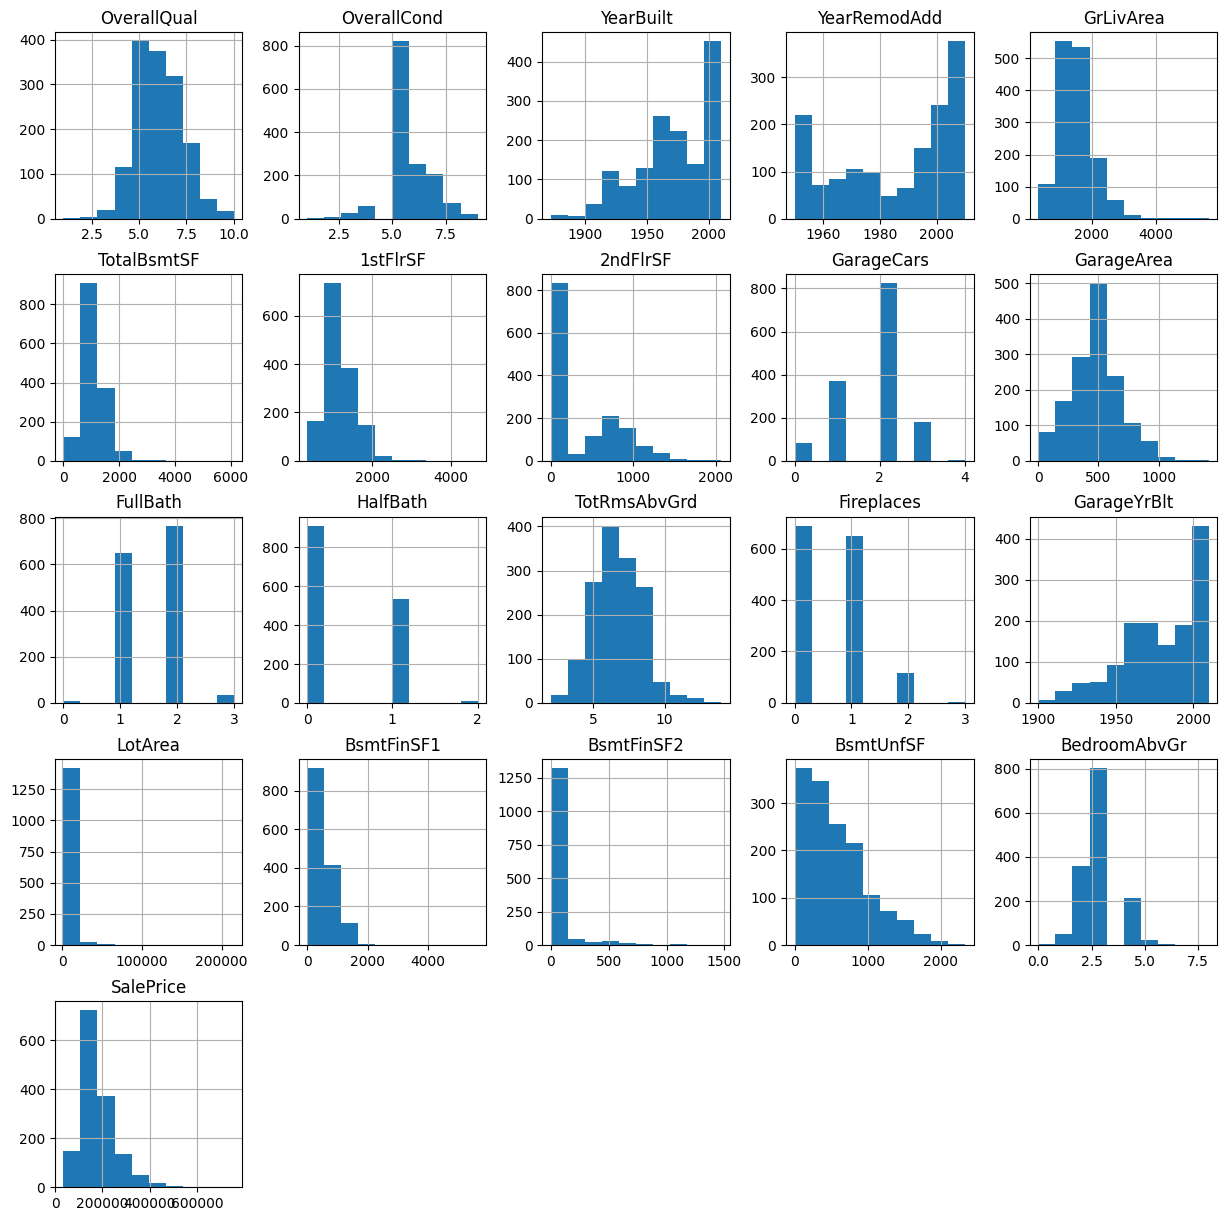

In [125]:
#Numerical features
num_features= ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GrLivArea',
               'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'GarageCars', 'GarageArea', 'FullBath',
               'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'LotArea', 
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','BedroomAbvGr', 'SalePrice']

train_data[num_features].hist(figsize=(15,15))
plt.show()

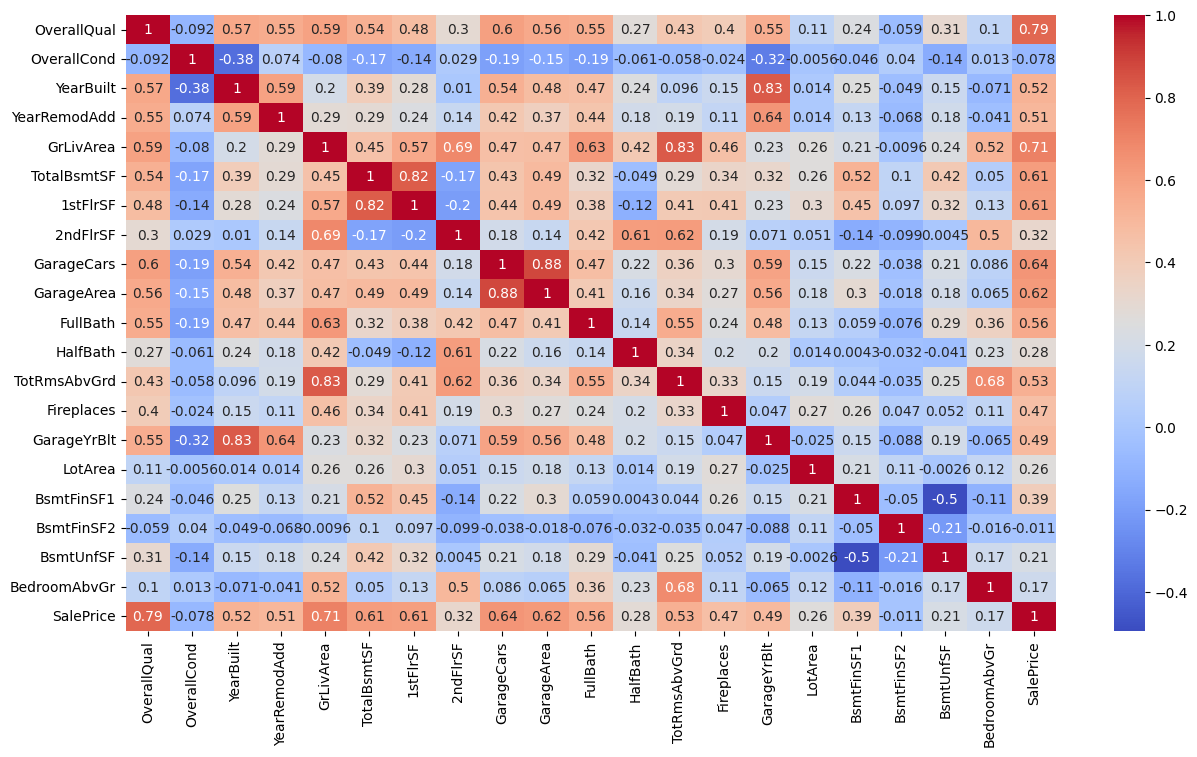

In [32]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data[num_features].corr(), annot=True, cmap="coolwarm")
plt.show()

I just want to check if any of the numerical features I have not included are strongly correlated to the sale price. 

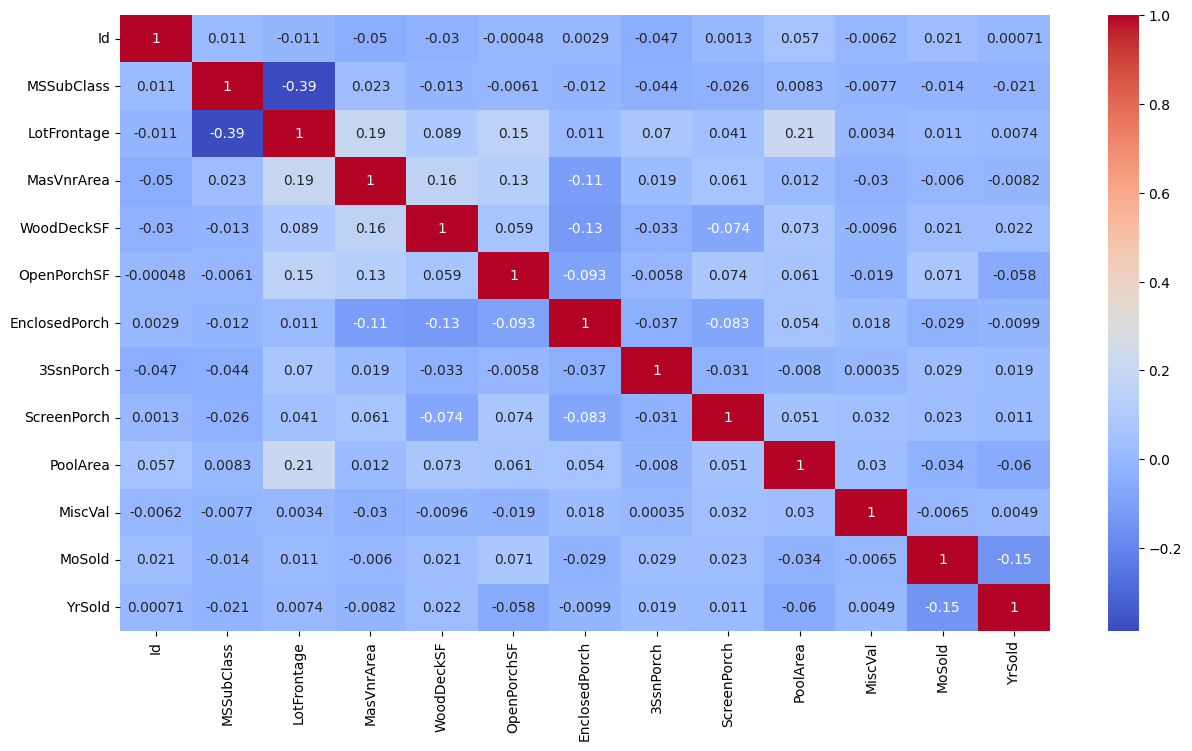

In [37]:
num_columns_extra = ['Id','MSSubClass','LotFrontage','MasVnrArea','WoodDeckSF','OpenPorchSF',
                     'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold',
                     'YrSold']

plt.figure(figsize=(15,8))
sns.heatmap(train_data[num_columns_extra].corr(), annot=True, cmap="coolwarm")
plt.show()

# Preprocessing
### 1. Skewness
Notice in the histograms for some of the features (LotArea, BsmtFinSF2, BsmtFinSF1) the graphs are skewed. I am going to check how skewed all of the numerical features are

In [227]:
skewness = train_data[num_features].skew().sort_values(ascending=False)
print(skewness)

LotArea         12.207688
BsmtFinSF2       4.255261
SalePrice        1.882876
BsmtFinSF1       1.685503
TotalBsmtSF      1.524255
1stFlrSF         1.376757
GrLivArea        1.366560
BsmtUnfSF        0.920268
2ndFlrSF         0.813030
OverallCond      0.693067
TotRmsAbvGrd     0.676341
HalfBath         0.675897
Fireplaces       0.649565
OverallQual      0.216944
BedroomAbvGr     0.211790
GarageArea       0.179981
FullBath         0.036562
GarageCars      -0.342549
YearRemodAdd    -0.503562
YearBuilt       -0.613461
GarageYrBlt     -0.649415
dtype: float64


**Highly Skewed**
- LotArea: 12.207688
- BsmtFinSF2: 4.255261
- BsmtFinSF1: 1.685503
- TotalBsmtSF: 1.524255
- 1stFlrSF: 1.376757
- GrLivArea: 1.366560

Some features are only moderatley skewed so I will take note of these and see if they significantly affect the model performance. If they are I will consider transforming them. 

**Moderatley skewed:**
- BsmtUnfSF: 0.920268
- 2ndFlrSF: 0.813030

In [256]:
skewed = ['LotArea','BsmtFinSF2','BsmtFinSF1','TotalBsmtSF','1stFlrSF', 'GrLivArea']

for feature in skewed:
    train_data[feature] = np.log(train_data[feature] + 1)

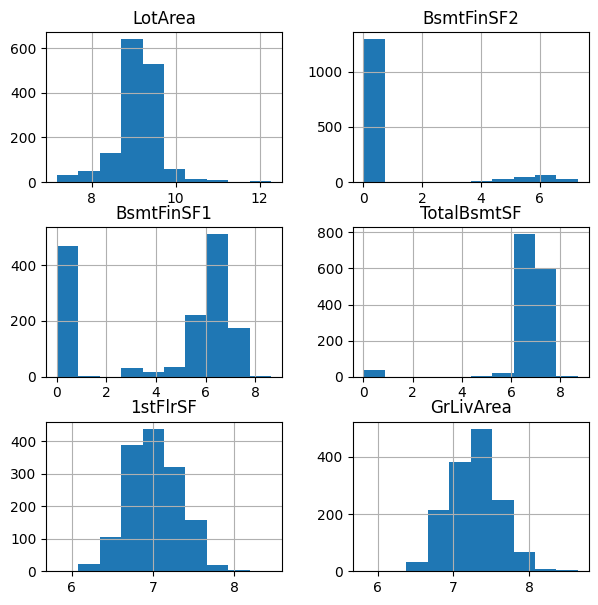

In [158]:
train_data[skewed].hist(figsize=(7,7))
plt.show()

### 2. Null Values
I want to investigate the null values in my table and see what I can do about them.

In [257]:
# Investigate which columns have null values
null_feat = train_data[features].isnull().sum()
null_feat[null_feat > 0]

FireplaceQu    690
GarageYrBlt     81
dtype: int64

**FireplaceQu** <br />
I think this is a result of the house not having a garage. I am going to check this. If I am right, there should be 690 null values in the GarageFinish column. If I am right, I will fix this by imputing a specific value: *No*. I will do one hot encoding on this column later (because it is a categorical column with 5 unique values), I will just encode this with 0 <br />
**GarageYrBlt** <br />
I think this is a result of the house not having a garage. I am going to check this. If I am right, there should be 81 null values in the GarageFinish column. If I am right, I will fix this by imputing a specific value: 0

In [182]:
#FireplaceQu
missing_fireplacequ = train_data[train_data['FireplaceQu'].isnull()]
no_fireplace_check = missing_fireplacequ[missing_fireplacequ['Fireplaces'] == 0].shape[0]
if no_fireplace_check == 690:
    print("Yay I was right about FireplaceQu :)")
else:
    print(f"Back to the dawing board :( you got {no_fireplace_check}")

Yay I was right about FireplaceQu :)


In [258]:
train_data['FireplaceQu'].fillna('No', inplace=True)
print(f"Number of nulls: {train_data['FireplaceQu'].isnull().sum()}")

Number of nulls: 0


In [184]:
#GarageYrBlt
missing_garage_yrb = train_data[train_data['GarageYrBlt'].isnull()]
no_garage_check = missing_garage_yrb['GarageFinish'].isnull().sum()
if no_garage_check == 81:
    print("Yay I was right about GarageYrBlt :)")
else:
    print(f"Back to the dawing board :( you got {no_garage_check}")

Yay I was right about GarageYrBlt :)


In [259]:
train_data['GarageYrBlt'].fillna(0, inplace=True)
print(f"Number of nulls: {train_data['GarageYrBlt'].isnull().sum()}")

Number of nulls: 0


### 3. Split the Data
I will split the data into training and validation sets. This ensures that your preprocessing steps are based solely on the training set and that the validation set remains a true representation of unseen data. (Avoid data leakage)

In [288]:
X = train_data[features]
y = train_data.SalePrice

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state=1)

In [373]:
# Make a copy before encoding
encoded_train_X, encoded_val_X = train_X.copy(), val_X.copy()

### 4. Dealing with Categorical Features

There are some categorical features. I still want to include them in my data because they are probabaly a contributing factory to the house value.

In [374]:
# Get categorical columns
s = X.dtypes=='object'
print(list(s[s].index))

['KitchenQual', 'FireplaceQu', 'Neighborhood', 'HeatingQC', 'CentralAir']


In [378]:
cat_features = ['KitchenQual', 'FireplaceQu', 'HeatingQC','CentralAir', 'Neighborhood']

for feature in cat_features:
    print(f"{feature}: {train_data[feature].unique()}")

KitchenQual: ['Gd' 'TA' 'Ex' 'Fa']
FireplaceQu: ['No' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
HeatingQC: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
CentralAir: ['Y' 'N']
Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


#### KitchenQual
Our unique values are ['Gd' 'TA' 'Ex' 'Fa']. I will use **ordinal encoding** for this becausse there is a clear assumed ordering for the values. The assigned values are: 
**Ex**: Excellent (4) > **Gd**: Good (3)> **TA**: Average (2) >  **Fa**: Fair (1)

In [379]:
categories = [['Fa', 'TA', 'Gd', 'Ex']] #In ascending order

encoder = OrdinalEncoder(categories=categories)

encoded_train_X[['KitchenQual']] = encoder.fit_transform(train_X[['KitchenQual']])
encoded_val_X[['KitchenQual']] = encoder.transform(val_X[['KitchenQual']])

#### FireplaceQu
Our unique values are ['No' 'TA' 'Gd' 'Fa' 'Ex' 'Po']. This is similar to above and I will use **ordinal encoding**. The assigned values are: 
**Ex**: Excellent (5) > **Gd**: Good (4)> **TA**: Average (3) >  **Fa**: Fair (2) > **Po**: Poor (1) > **No**: No Fireplace (0) 

In [380]:
categories = [['No','Po','Fa', 'TA', 'Gd', 'Ex']] #In ascending order

encoder = OrdinalEncoder(categories=categories)

encoded_train_X[['FireplaceQu']] = encoder.fit_transform(train_X[['FireplaceQu']])
encoded_val_X[['FireplaceQu']] = encoder.transform(val_X[['FireplaceQu']])

#### HeatingQC
Our unique values are ['TA' 'Gd' 'Fa' 'Ex' 'Po']. Again, this is similar to above and I will use **ordinal encoding**. The assigned values are: 
**Ex**: Excellent (5) > **Gd**: Good (4)> **TA**: Average (3) >  **Fa**: Fair (2) > **Po**: Poor (1) 

In [381]:
categories = [['Po','Fa', 'TA', 'Gd', 'Ex']] #In ascending order

encoder = OrdinalEncoder(categories=categories)

encoded_train_X[['HeatingQC']] = encoder.fit_transform(train_X[['HeatingQC']])
encoded_val_X[['HeatingQC']] = encoder.transform(val_X[['HeatingQC']])

#### CentralAir
Our unique values are ['Y' 'N']. These do not have an inherit ordering. So I will use **OneHot encoding**

In [382]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[['CentralAir']]), columns=OH_encoder.get_feature_names_out(['CentralAir']))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[['CentralAir']]), columns=OH_encoder.get_feature_names_out(['CentralAir']))

# Put index back and remove CentralAir column
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index
num_X_train = encoded_train_X.drop(['CentralAir'], axis=1)
num_X_valid = encoded_val_X.drop(['CentralAir'], axis=1)

encoded_train_X = pd.concat([num_X_train, OH_cols_train], axis=1)
encoded_val_X = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [383]:
encoded_train_X[['CentralAir_N','CentralAir_Y']].head()

,CentralAir_N,CentralAir_Y
921,0.0,1.0
520,1.0,0.0
401,0.0,1.0
280,0.0,1.0
1401,0.0,1.0


#### Neighborhood
There are a lot of unique values for this so OneHot encoding might be impractical. But there is no obvious assumed ordering either. I will just explore this feature a little bit more and try to understand it

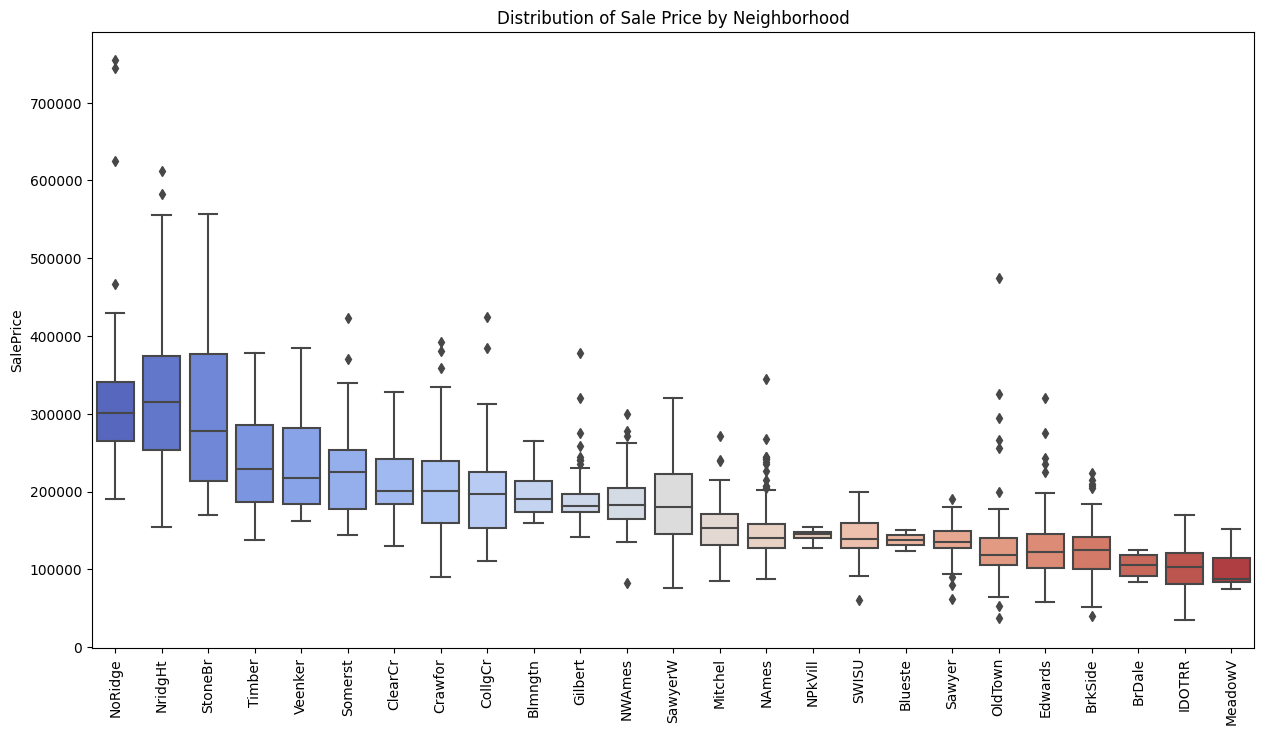

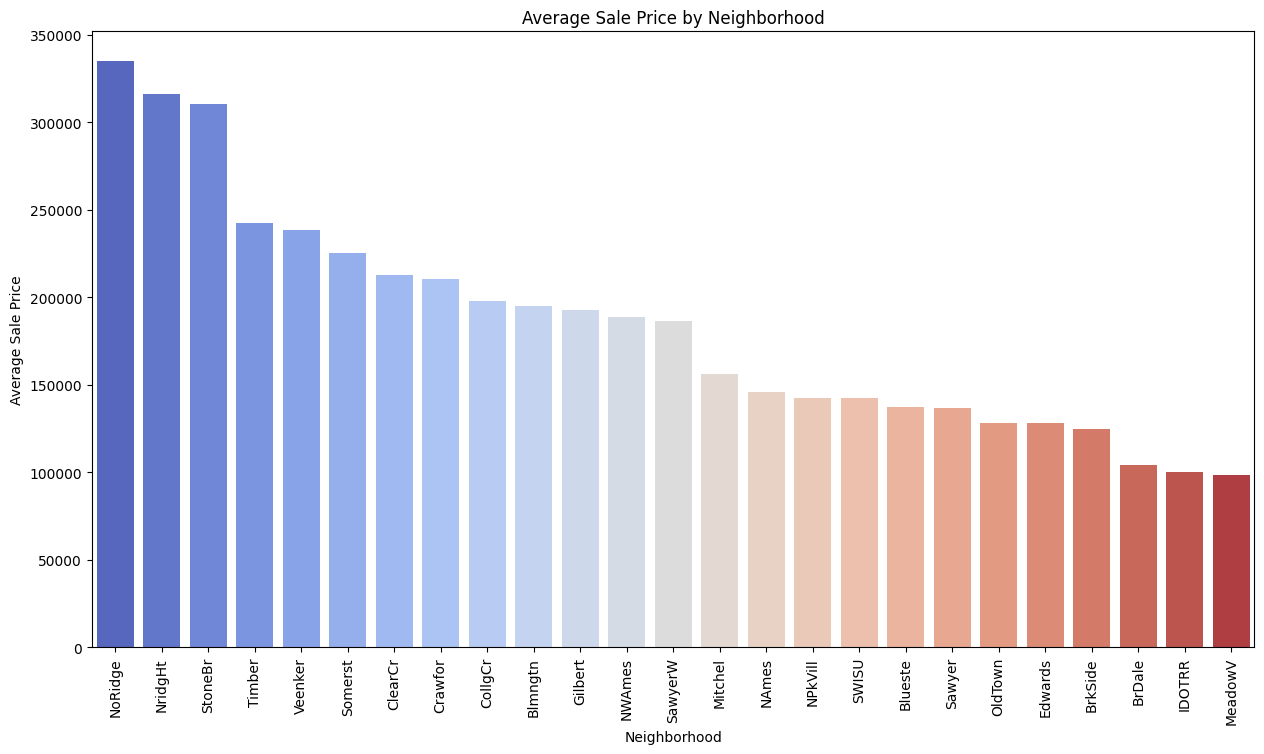

In [384]:
neighborhood_price = train_data.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False)
neighborhood_order = neighborhood_price.index

plt.figure(figsize=(15, 8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_data, palette='coolwarm', order=neighborhood_order)
plt.xticks(rotation=90)
plt.xlabel('')
plt.title('Distribution of Sale Price by Neighborhood')

plt.figure(figsize=(15, 8))
sns.barplot(x=neighborhood_price.index, y=neighborhood_price.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price by Neighborhood')
plt.show()

I want to see if it is worth keeping this column. I will run an **ANOVA** (Analysis of Variance) test to see the statistical significance of the neighborhood on the sale price. 
- **F-statistic**:
    - The F-statistic measures how much the means of different groups (in your case, different neighborhoods) differ relative to the variance within each group.
    - A high F-statistic suggests that there is more variability between the groups than within the groups, indicating that the group means are different.
- **p-value**: 
    - The p-value indicates the probability of observing the data, or something more extreme, assuming the null hypothesis (no effect) is true.
    - A very low p-value (typically less than 0.05) indicates strong evidence against the null hypothesis.

In [385]:
F_stat, p_value = stats.f_oneway(*[train_data[train_data['Neighborhood'] == neighborhood]['SalePrice'] for neighborhood in train_data['Neighborhood'].unique()])
print(f"F-statistic: {F_stat}")
print(f"p-value: {p_value}")

F-statistic: 71.78486512058272
p-value: 1.558600282771154e-225


The results of the ANOVA test indicate that there are statistically significant differences in SalePrice between the different neighborhoods. This suggests that the Neighborhood feature has a significant impact on SalePrice, and it is worth keeping this feature in the model. Considering this, I will use target encoding (also known as mean encoding) for this variable. 

**Target Encoding**
-  This method replaces each category with the mean of the target variable (SalePrice in our case) for that category. It’s particularly useful for categorical features with many unique values. 

In [386]:
target_encoder = ce.TargetEncoder(cols=['Neighborhood'])

encoded_train_X['Neighborhood'] = target_encoder.fit_transform(train_X['Neighborhood'], train_y)
encoded_val_X['Neighborhood'] = target_encoder.transform(val_X['Neighborhood'])

#### View The Encoded Table

In [387]:
# Compare encoded_train_X and train_X
cat_features2 = ['KitchenQual', 'FireplaceQu', 'HeatingQC', 'Neighborhood', 'CentralAir_N','CentralAir_Y']
display(HTML(f"""<table><tr><td>{encoded_train_X[cat_features2].head(10).to_html()}</td><td>{train_X[cat_features].head(10).to_html()}</td></tr></table>"""))

,KitchenQual,FireplaceQu,HeatingQC,Neighborhood,CentralAir_N,CentralAir_Y
921,1.0,0.0,3.0,129275.257809,0.0,1.0
520,1.0,0.0,2.0,129313.556023,1.0,0.0
401,2.0,4.0,4.0,197700.668339,0.0,1.0
280,2.0,3.0,3.0,191511.783519,0.0,1.0
1401,1.0,3.0,4.0,192145.735316,0.0,1.0
131,2.0,3.0,4.0,192145.735316,0.0,1.0
808,1.0,4.0,2.0,148169.131608,0.0,1.0
1249,1.0,0.0,2.0,148169.131608,0.0,1.0
1083,1.0,4.0,2.0,148169.131608,0.0,1.0
613,1.0,0.0,4.0,161750.153152,0.0,1.0


In [388]:
# List unique values for previously categorical features
for feature in cat_features2:
    print(f"{feature}: {encoded_train_X[feature].unique()}")

KitchenQual: [1. 2. 3. 0.]
FireplaceQu: [0. 4. 3. 2. 5. 1.]
HeatingQC: [3. 2. 4. 1.]
Neighborhood: [129275.25780905 129313.55602327 197700.66833923 191511.78351873
 192145.73531564 148169.13160839 161750.15315249 189108.70252713
 223723.0940883  126487.95977683 172340.14510404 314962.63615525
 212017.44366314 255885.40957181 187161.22922686 283267.9353171
 128416.50763982 138755.31626126 159402.4739521  154316.37652919
 229457.65161851 201840.29282907 158593.56278124 190744.58787782
 174634.94308757]
CentralAir_N: [0. 1.]
CentralAir_Y: [1. 0.]


# Define Model
I will be using a random forest regressor as my model.

In [389]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)

rf_model.fit(encoded_train_X, train_y)
rf_val_predictions = rf_model.predict(encoded_val_X)

# Evaluate model 

In [390]:
min_price = train_data['SalePrice'].min()
max_price = train_data['SalePrice'].max()
print(f"Minimum SalePrice: {min_price}")
print(f"Maximum SalePrice: {max_price}")

Minimum SalePrice: 34900
Maximum SalePrice: 755000


The SalePrice of a house is between \\$34,900 and $755,000

How I will measure accuracy:
- **Mean Absolute Error** (MAE): Is the average of the absolute differences between the predicted values and the actual values. It indicates the average magnitude of errors in your predictions. Lower is better.
- **Mean Squared Error (MSE)**: Measures the average squared difference between the predicted values and the actual values. A lower MSE indicates better model performance, but since it squares the errors, it is sensitive to outliers and may not be as interpretable in terms of the original units of the target variable.
- **Root Mean Squared Error** (RMSE): Is the square root of MSE and provides a measure of the average magnitude of the errors. It can be easier to understand and communicate  than MSE because it gives a sense of the average magnitude of the errors.
- **R² Score** (R-Squared): (coefficient of determination) Shows the proportion of variance explained by the model. A value close to 1 indicates a good fit.

Note that this competition is judged on MSE

In [399]:
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
fr_val_mse = mean_squared_error(val_y, rf_val_predictions)
rf_val_rmse = np.sqrt(fr_val_mse)
rf_val_r2 = r2_score(val_y, rf_val_predictions)

print("Mean Absolute Error: {:,.0f}".format(rf_val_mae))
print(f'Mean Squared Error (MSE): {fr_val_mse}')
print(f'Root Mean Squared Error (RMSE): {rf_val_rmse}')
print(f"R^2 Score: {rf_val_r2}")

Mean Absolute Error: 15,166
Mean Squared Error (MSE): 505306699.1469689
Root Mean Squared Error (RMSE): 22479.02798492339
R^2 Score: 0.9291488066478195


**Mean Absolute Error** 
- On average, the model’s predictions are off by \\$15,166 from the actual values 
- Considering the sale prices range from \\$34,900 to \$755,000, the MAE represents roughly 2.5% to 43% of the sale price. This suggests that while the model's average error is significant, it is reasonably small relative to the total price range.

**Root Mean Squared Error** 
- On average, the model’s predictions are off by approximately $22,479.03 
- \\$22,479.03 is approximately 3% to 64% of the sale price, depending on the house's actual sale price. This means the average error is substantial, but considering the wide range of sale prices, it reflects the model's performance with respect to varying house values.

**R² Score**
- Approximately 92.9% of the variance in the target variable can be explained by the model. This is a high R² value, suggesting that the model fits the data very well and explains a significant portion of the variance in the target variable.

These values are pretty good!! I want to visualize the accuracy of the model 

### Visualize model
In an ideal scenario, the points would be close to a 45-degree line (line of equality) where Actual Sale Price equals Predicted Sale Price.

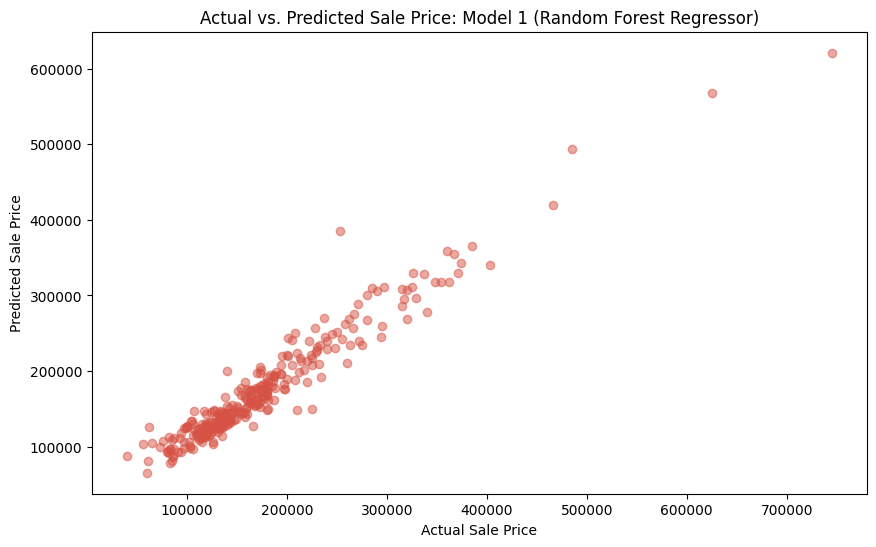

In [439]:
plt.figure(figsize=(10, 6))
plt.scatter(val_y, rf_val_predictions, alpha=0.5, color = cmap(0.9))
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Price: Model 1 (Random Forest Regressor)')
plt.show()

This model is pretty good. It appears to somewhat resemble a 45 degree line. I am now going to make some improvements.

# Cross Validation
Cross-validation splits the data into multiple training and validation sets to evaluate the model’s performance and robustness. It averages the results to provide a more reliable measure of how well the model generalizes to unseen data.

Steps:
1. **GridSearchCV Initialization:**
    - Set up GridSearchCV to optimize for MSE ('neg_mean_squared_error').
2. **Model Fitting:**
    - Train the model with the grid search on the training data.
3. **Best Parameters and Score:**
    - Print the best parameters and MSE score.
4. **Model Evaluation:**
    - Use the best best model from the grid search to make predictions on the validation set, and calculate MSE.

In [400]:
#1
model = RandomForestRegressor(random_state=1)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
#2
grid_search.fit(encoded_train_X, train_y)

#3
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score (MSE): {-grid_search.best_score_}")


Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best score (MSE): 883174110.8750391
Validation MSE: 527937019.0061122


In [411]:
#4
best_model = grid_search.best_estimator_
cross_val_predictions = best_model.predict(encoded_val_X)

cross_mae = mean_absolute_error(cross_val_predictions, val_y)
cross_mse = mean_squared_error(val_y, cross_val_predictions)
cross_rmse = np.sqrt(cross_mse)
cross_r2 = r2_score(val_y, cross_val_predictions)

print("Mean Absolute Error: {:,.0f}".format(cross_mae))
print(f'Mean Squared Error (MSE): {cross_mse}')
print(f'Root Mean Squared Error (RMSE): {cross_rmse}')
print(f"R^2 Score: {cross_r2}")

Mean Absolute Error: 15,376
Mean Squared Error (MSE): 527937019.0061122
Root Mean Squared Error (RMSE): 22976.880097308953
R^2 Score: 0.9259757136121075


**Mean Absolute Error** 
- On average, the model’s predictions are off by \\$15,376 from the actual values 

**Root Mean Squared Error** 
- On average, the model’s predictions are off by approximately $22,976.88

**R² Score**
- Approximately 92.6% of the variance in the target variable can be explained by the model.

Although some of these values are slightly worse than what we had before, this is ok because these parameters are set to predict the overall data better. Not just this validation set. 

### Visual Representation of Model

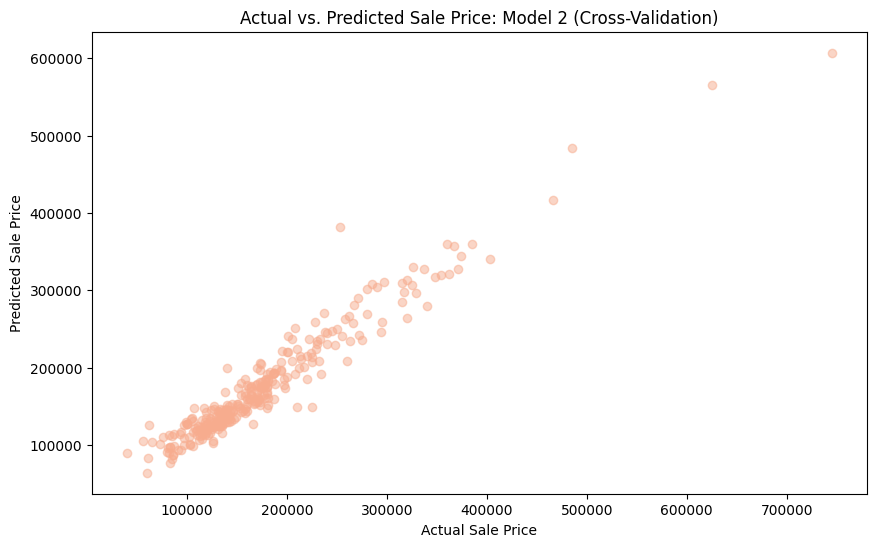

In [438]:
plt.figure(figsize=(10, 6))
plt.scatter(val_y, cross_val_predictions, alpha=0.5, color = cmap(0.7))
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Price: Model 2 (Cross-Validation)')
plt.show()

This is good too! But I want to make a furhter improvement.

# XGBoost (with Cross-Validation)
XGBoost builds a series of decision trees sequentially, where each tree corrects the errors of the previous ones. It uses gradient boosting techniques and regularization to improve accuracy and prevent overfitting.

In [407]:
xgb_model = xgb.XGBRegressor(random_state=1)

In [408]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_xgb.fit(encoded_train_X, train_y)

print(f"Best parameters for MSE: {grid_search_xgb.best_params_}")
print(f"Best score (MSE): {-grid_search_xgb.best_score_}")

Best parameters for MSE: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best score (MSE): 754297147.6768547


In [413]:
best_xgb_model = grid_search_xgb.best_estimator_

xgb_val_predictions = best_xgb_model.predict(encoded_val_X)

xgb_mae = mean_absolute_error(xgb_val_predictions, val_y)
xgb_mse = mean_squared_error(val_y, xgb_val_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(val_y, xgb_val_predictions)

print("Mean Absolute Error: {:,.0f}".format(xgb_mae))
print(f'Mean Squared Error (MSE): {xgb_mse}')
print(f'Root Mean Squared Error (RMSE): {xgb_rmse}')
print(f"R^2 Score: {xgb_r2}")

Mean Absolute Error: 14,872
Mean Squared Error (MSE): 527363271.027355
Root Mean Squared Error (RMSE): 22964.391370714682
R^2 Score: 0.9260561612472704


**Mean Absolute Error** 
- On average, the model’s predictions are off by \\$14,872 from the actual values 

**Root Mean Squared Error** 
- On average, the model’s predictions are off by approximately $22,964.39

**R² Score**
- Approximately 92.6% of the variance in the target variable can be explained by the model.

### Visual Representation of Model

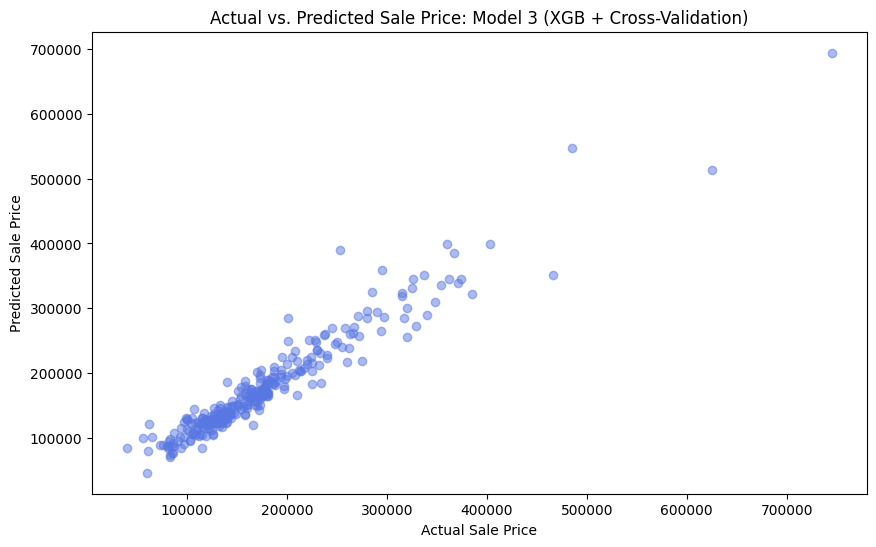

In [437]:
plt.figure(figsize=(10, 6))
plt.scatter(val_y, xgb_val_predictions, alpha=0.5, color = cmap(0.1))
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Price: Model 3 (XGB + Cross-Validation)')
plt.show()